In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import sklearn.model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
#import dataset and look at column names
shot_orig = pd.read_csv('shot_logs.csv')
shot_orig.shape

(128069, 21)

In [3]:
shot_orig.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [4]:
# Get rid of game_id as it will not contribute my final model

# Get rid of win and final_margin as they are only known after a game is over,
# and I am trying to model shots taken during a game, so they would not contribute to my final.  

# Get rid of player_name, player_id, closest_defender, closest_defender_player_id,matchup, location because
# these are NBA specific, and I would like to generalize to all basketball games.

shot = shot_orig.loc[: , ['SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
                     'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSE_DEF_DIST', 'PTS']]
shot.head()

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS
0,1,1,1:09,10.8,2,1.9,7.7,2,made,1.3,2
1,2,1,0:14,3.4,0,0.8,28.2,3,missed,6.1,0
2,3,1,0:00,NaN,3,2.7,10.1,2,missed,0.9,0
3,4,2,11:47,10.3,2,1.9,17.2,2,missed,3.4,0
4,5,2,10:34,10.9,2,2.7,3.7,2,missed,1.1,0


In [5]:
# find if game_clock refers to the time left in the whole game, or just the period
#shot.GAME_CLOCK

# it seems that none of the time goes above 12, so game_clock refers to just the period

In [6]:
pd.DataFrame(shot.dtypes)

# Everything is numeric except for GAME_CLOCK and SHOT_RESULT

,0
SHOT_NUMBER,int64
PERIOD,int64
GAME_CLOCK,object
SHOT_CLOCK,float64
DRIBBLES,int64
TOUCH_TIME,float64
SHOT_DIST,float64
PTS_TYPE,int64
SHOT_RESULT,object
CLOSE_DEF_DIST,float64


In [7]:
# convert game_clock to float
#first replace the colon with a period
shot.GAME_CLOCK = shot.GAME_CLOCK.str.replace(':', '.', regex=True)

#convert game_clock into float
shot.GAME_CLOCK = shot.GAME_CLOCK.astype('float')
type(shot.GAME_CLOCK[1])


numpy.float64

In [8]:
#convert shot_result to bool. 1 if made, 0 if missed
shot.SHOT_RESULT = shot.SHOT_RESULT == 'made'

In [9]:
shot.describe(include = 'all')

,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS
count,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069,128069.000000,128069.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70164,NaN,NaN
mean,6.506899,2.469427,5.663617,12.453344,2.023355,2.765901,13.571504,2.264670,NaN,4.123015,0.997314
std,4.713260,1.139919,3.451461,5.763265,3.477760,3.043682,8.888964,0.441159,NaN,2.756446,1.130978
min,1.000000,1.000000,0.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,NaN,0.000000,0.000000
25%,3.000000,1.000000,2.520000,8.200000,0.000000,0.900000,4.700000,2.000000,NaN,2.300000,0.000000
50%,5.000000,2.000000,5.520000,12.300000,1.000000,1.600000,13.700000,2.000000,NaN,3.700000,0.000000
75%,9.000000,3.000000,8.510000,16.675000,2.000000,3.700000,22.500000,3.000000,NaN,5.300000,2.000000


In [10]:
misvals = pd.DataFrame(pd.DataFrame(shot.describe(include = 'all')).iloc[0, :])
misvals['percentage of missing values'] = (128069 - misvals['count']) / 128069
misvals

# it seems that all columns except for shot_clock have the full 128069 values
# shot_clock is only missing less than 5% of its values, so dropping the column would not be considered

,count,percentage of missing values
SHOT_NUMBER,128069,0
PERIOD,128069,0
GAME_CLOCK,128069,0
SHOT_CLOCK,122502,0.0434688
DRIBBLES,128069,0
TOUCH_TIME,128069,0
SHOT_DIST,128069,0
PTS_TYPE,128069,0
SHOT_RESULT,128069,0
CLOSE_DEF_DIST,128069,0


In [11]:
#fill the NaN in shot_clock with the mean

shot[['SHOT_CLOCK']] = shot[['SHOT_CLOCK']].fillna(shot[['SHOT_CLOCK']].mean())

In [12]:
# maybe use fancy impute instead?

In [13]:
# Using the cleaned 'shot' data frame, I will use shot_result as my target column and everything else except pts
# as my input columns.  I am excluding pts as it details the amount of points resulting from the shot, so it would
# not be a good predictor of shot_result.  I am keeping the column, however, because I may use pts as my target column
# in a different model. 

sum(shot.SHOT_RESULT) / len(shot.SHOT_RESULT)

# The shot_result column is boolean, with 1 being if the shot was made, and 0 being if the shot was missed.  It
# seems that about 45% of all total shots are made.

0.4521390812764994

In [14]:
#create data frame where shot was missed and shot was made for some eda
shot_made = shot.loc[shot['SHOT_RESULT'] == 1, :]
shot_missed = shot.loc[shot['SHOT_RESULT'] == 0, :]

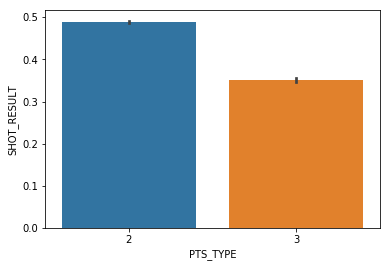

In [15]:
#comparing makes and misses for 2 point shots vs 3 point shots

sns.barplot(x = shot.PTS_TYPE, y = shot.SHOT_RESULT)

#as expected, shots worth 2 points have a much higher percentage (around 49%) than shots worth 3 points (around 35%)

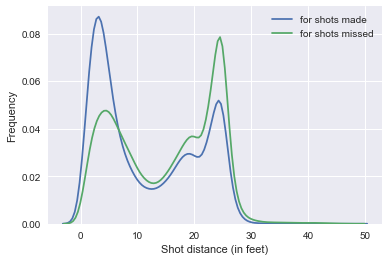

In [16]:
# EDA for a few variables that probably impact probability of shot being made

# two line histograms of shot distances
sns.set()
sns.distplot(shot_made['SHOT_DIST'], hist = False, label = 'for shots made')
sns.distplot(shot_missed['SHOT_DIST'], hist = False, label = 'for shots missed')
plt.ylabel('Frequency')
plt.xlabel('Shot distance (in feet)')
plt.show()

# the two distributions are definitely different, with, as expected, more shots being made the closer the shot
# is taken to the rim.  Of note is the two peaks at the same distance for both line histograms.  The first
# peak represents shots taken close to the rim, meaning probably layups or dunks.  The second peak represents
# the distance for a three point shot.  The little bump in the second peak most likely represents corner three
# point shots, which are closer to the rim than other three point shots.

/Users/ray/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ray/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


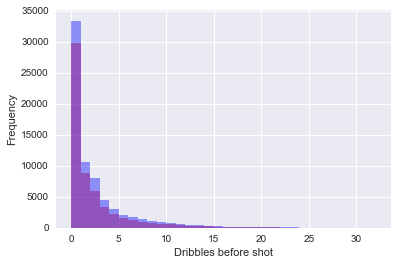

In [17]:
# two line histograms of dribbles taken
sns.set()
sns.distplot(shot_made['DRIBBLES'], kde = False, color = 'red',
             bins = np.arange(shot_made['DRIBBLES'].min(), shot_made['DRIBBLES'].max() + 1))
sns.distplot(shot_missed['DRIBBLES'], kde = False, color = 'blue',
             bins = np.arange(shot_missed['DRIBBLES'].min(), shot_missed['DRIBBLES'].max() + 1))
plt.xlabel('Dribbles before shot')
plt.ylabel('Frequency')
plt.show()

# at a first glance, it seems that the number of dribbles taken before the shot does not affect affect
# whether or not the shot was made, as the frequencies seem to decrease equally 

/Users/ray/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/ray/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


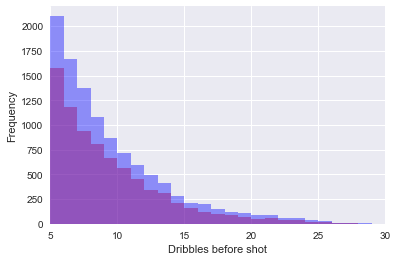

In [18]:
# zoomed in version of previous plot for 5 dribbles or more

sns.set()
sns.distplot(shot_made['DRIBBLES'], kde = False, color = 'red',
             bins = np.arange(shot_made['DRIBBLES'].min(), shot_made['DRIBBLES'].max() + 1))
sns.distplot(shot_missed['DRIBBLES'], kde = False, color = 'blue',
             bins = np.arange(shot_missed['DRIBBLES'].min(), shot_missed['DRIBBLES'].max() + 1))
plt.xlabel('Dribbles before shot')
plt.ylabel('Frequency')
plt.xlim(5, 30)
plt.ylim(0, 2200)
plt.show()

# with a closer look, it seems that the frequency of dribbles before shot still decrease at the same rate for both
# shots made and missed

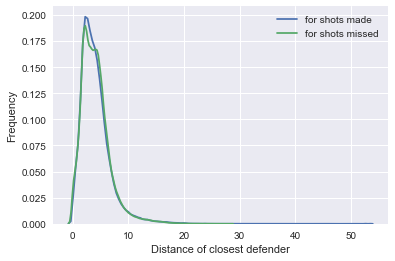

In [19]:
# two line histograms of closest defender
sns.set()
sns.distplot(shot_made['CLOSE_DEF_DIST'], hist = False, label = 'for shots made')
sns.distplot(shot_missed['CLOSE_DEF_DIST'], hist = False, label = 'for shots missed')
plt.ylabel('Frequency')
plt.xlabel('Distance of closest defender')
plt.show()

In [102]:
#modeling

# create and isolate list of shot_results as boolean
shot_y = shot.SHOT_RESULT == 'missed'

#create dataframe of non-object independent variables 
shot_X = shot[['SHOT_NUMBER', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_CLOCK',
              'SHOT_DIST', 'CLOSE_DEF_DIST', 'PTS_TYPE']]

In [103]:
# split data into training and testing

Xtrain, Xtest, ytrain, ytest = train_test_split(shot_X, shot_y, test_size = .25,
                                               random_state = 99)

In [104]:
# attempt to find the percentage of shot_result for different kinds
# kinds of shots first

# use a logistic regression to classify whether or not shot was made

lr = LogisticRegression()
lr.fit(Xtrain, ytrain)
print(accuracy_score(lr.predict(Xtest), ytest))
print(accuracy_score(lr.predict(Xtrain), ytrain))

# simple model seems to be very inaccurate with training and testing data.
# curiously enough, the two accuracy scores are very similar, and it is
# actually higher for the test data.
# This is probably a due to the fact that basketball shots percentages are
# highly volatile in and of themselves.  Repeated basketball shots, when
# when taken in the exact same context, is still most likely comprised of
# both makes and misses.

0.6106252732837779
0.6088640409782303


In [106]:
# Fine-tuning the model
Cs = [0.001, 0.1, 1, 10, 100]

parameters = {'C' : Cs}
cgrid = GridSearchCV(lr, param_grid = parameters, cv = 5)
cgrid.fit(Xtrain, ytrain)
cgrid.best_estimator_, cgrid.best_params_, cgrid.best_score_, cgrid.grid_scores_

/Users/ray/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


(LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 {'C': 0.001},
 0.6082706062404347,
 [mean: 0.60827, std: 0.00332, params: {'C': 0.001},
  mean: 0.60827, std: 0.00337, params: {'C': 0.1},
  mean: 0.60826, std: 0.00339, params: {'C': 1},
  mean: 0.60827, std: 0.00339, params: {'C': 10},
  mean: 0.60827, std: 0.00339, params: {'C': 100}])